In [1]:
import dit
import os

import numpy as np
import pandas as pd
from collections import Counter

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import auc

from dit import ScalarDistribution

import matplotlib.pyplot as plt
%matplotlib inline

from src.data_loader import Shifted_Data_Loader


Using TensorFlow backend.


In [2]:
dataset='fashion_mnist'
data_root = '../data/style_embeddings/'
tx_vals = np.arange(10)/10.
z_dfs = [pd.read_pickle(os.path.join(data_root,'merge_{}.pk'.format(tx))) for tx in tx_vals]


In [3]:
z_dfs[3].head()

,dx,dy,z_enc,class_id,isomap_dim_1,scaled_isomap_dim_1
0,2.0,-3.0,"[2.62276291847229, -9.880125999450684, -0.9262...",9,2501.723983,7.665259
1,2.0,-2.0,"[-12.732379913330078, 4.377309322357178, 3.792...",2,2509.234302,6.727526
2,-4.0,2.0,"[-5.7194905281066895, -10.652034759521484, -17...",1,227.763048,4.840256
3,2.0,-1.0,"[2.5953481197357178, 0.31615516543388367, -0.3...",1,764.240528,6.231729
4,-2.0,-4.0,"[-3.6004459857940674, -3.639430284500122, 3.46...",6,-344.645871,-2.835388


In [4]:
z_dfs[3]
z_encodings = [np.array(df.z_enc.values.tolist()) for df in z_dfs]
dxs = np.array([df.dx.values.tolist() for df in z_dfs],dtype=int)+14
dys = np.array([df.dy.values.tolist() for df in z_dfs],dtype=int)+14
iso = np.array([df.isomap_dim_1.values.tolist() for df in z_dfs])
cids = np.array([df.class_id.values.tolist() for df in z_dfs])

In [5]:
class RunResult():
    def __init__(self,z_encodings,dx,dy,iso,class_id):
        self.z_encoding_raw = z_encodings
        self.z_dim = z_encodings.shape[-1]
        self.dx = dx
        self.dy = dy
        self.isomap_1D_raw = iso
        self.class_id = class_id
        
    def z_enc(self,feat_range=50):
        z_n = [self.z_encoding_raw[:,n] for n in np.arange(self.z_dim)]
        return [MinMaxScaler(feature_range=(0,feat_range)).fit_transform(nvec.reshape(-1,1)).flatten().astype(int) for nvec in z_n]

    def iso(self,feat_range=50):
        return MinMaxScaler(feature_range=(0,feat_range)).fit_transform(self.isomap_1D_raw.reshape(-1,1)).flatten().astype(int)
    
    def z_enc_joint_dist(self,X):

        n_vec = [Counter(zip(n,X)) for n in self.z_enc()]
        n_pmf = [{k:v/float(sum(C.values())) for k,v in C.items()} for C in n_vec]
        n_cdists = [dit.Distribution(d) for d in n_pmf]
    #     n_dists = [ScalarDistribution(d) for d in n_pmf]

        return n_cdists
    
    def entropy(self,X):
        jdists = self.z_enc_joint_dist(X)
        
        return [dit.shannon.entropy(d) for d in jdists]
    
    def mutual_info(self,X):
        jdists = self.z_enc_joint_dist(X)
        
        return [dit.shannon.mutual_information(d,[0],[1]) for d in jdists]
        
    def conditional_entropy(self,X):
        jdists = self.z_enc_joint_dist(X)
        
        cond_H = [dit.shannon.mutual_information(d,[1],[0]) for d in jdists]
        
        return cond_H


# n,dx = make_joint_dists(z_encodings[3],dxs[3])

In [6]:
result_set = [RunResult(z_encodings[i],dxs[i],dys[i],iso[i],cids[i]) for i in np.arange(10)]

In [7]:
z_dx_I = [rr.mutual_info(rr.dx) for rr in result_set]

In [8]:
z_dy_I = [rr.mutual_info(rr.dy) for rr in result_set]

In [9]:
z_iso_I = [rr.mutual_info(rr.iso(feat_range=50)) for rr in result_set]

In [10]:
z_class_I = [rr.mutual_info(rr.class_id) for rr in result_set]

In [11]:
z_I_df = [pd.DataFrame.from_records({'dx':x,'dy':y,'style':i,'class':c}) for x,y,i,c in zip(z_dx_I,z_dy_I,z_iso_I,z_class_I)]

In [17]:
for df,tx in zip(z_I_df,tx_vals):
    df['translation']=tx
    df['xcov']=10

In [19]:
pd.concat(z_I_df).to_pickle('../data/style_embeddings/z_I.pk')

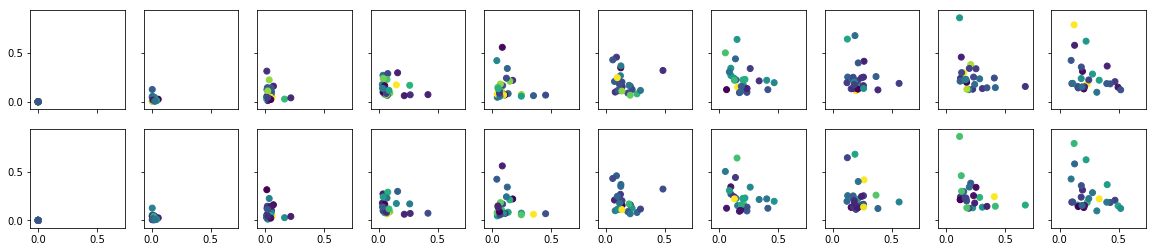

In [13]:
fig,axs = plt.subplots(2,10,figsize=(20,4),sharey=True,sharex=True)
# ax.set_ylim(-0.1,0.8)
# ax.set_xlim(-0.1,0.8)
df = z_I_df[6]
points = []
for df,i in zip(z_I_df,np.arange(10)):
    pts_0 = axs[0,i].scatter(df['dx'],df['dy'],c=df['class'],cmap='viridis')
    pts_1 = axs[1,i].scatter(df['dx'],df['dy'],c=df['style'])
    
# plt.colorbar(points[0])
# sns.scatterplot(x='dx',y='dy',hue='class',data=z_I_df[5],palette='plasma',legend=False)

In [14]:
# z_I_df = [df['spatial_var']=tx for df,tx in zip(z_I_df,tx_vals)]

In [15]:
rr = result_set[5]

In [ ]:
plt.plot(tx_vals,np.array(z_dx_I).mean(axis=1))
plt.plot(tx_vals,np.array(z_dy_I).mean(axis=1))
plt.plot(tx_vals,np.array(z_iso_I).mean(axis=1))
plt.plot(tx_vals,np.array(z_class_I).mean(axis=1))
plt.legend(['dx','dy','style','class'])
plt.xlabel('Spatial Variation')
plt.ylabel('Avg Mutual Info')

In [ ]:
import seaborn as sns
sns.set_context('talk')
fig,axs = plt.subplots(4,10,sharex=True,sharey=True,figsize=(20,6))
for fx,fy,fisos,fclass,i in zip(z_dx_I,z_dy_I,z_iso_I,z_class_I,np.arange(10)):
    axs[0,i].scatter(np.arange(25),sorted(fx,reverse=True))
    axs[1,i].scatter(np.arange(25),sorted(fy,reverse=True))
    axs[2,i].scatter(np.arange(25),sorted(fisos,reverse=True))
    axs[3,i].scatter(np.arange(25),sorted(fclass,reverse=True))

    axs[0,0].set_ylabel('I(dX|Z)')
    axs[1,0].set_ylabel('I(dY|Z)')
    axs[2,0].set_ylabel('I(S|Z)')
    axs[3,0].set_ylabel('I(C|Z)')
    
    for ax in axs[3]:
        ax.set_xticks([])
plt.tight_layout()

plt.savefig('../figures/2019-01-28/unit_shanon_waterfall.png')

In [ ]:
plt.plot(tx_vals,[auc(np.arange(25)/25.0,z_dx_I[i]) for i in np.arange(10)])
plt.plot(tx_vals,[auc(np.arange(25)/25.0,z_dy_I[i]) for i in np.arange(10)])
plt.plot(tx_vals,[auc(np.arange(25)/25.0,z_iso_I[i]) for i in np.arange(10)])
plt.plot(tx_vals,[auc(np.arange(25)/25.0,z_class_I[i]) for i in np.arange(10)])
plt.legend(['dx','dy','style','class'])
plt.xlabel('Spatial Variation')
plt.ylabel('AUC ()')
plt.tight_layout()
plt.savefig('../figures/2019-01-28/shannon_auc_vs_spatial_variation.png')